In [1405]:
with open("seed.txt", "r") as f:
    seed = int(f.read().strip())

print(f"seed = {seed}")

seed = 52772


In [1406]:
#Task 1: Regression — Regularization on Housing Data
#1.1 1A. Data Preprocessing (Required)
#1. Use your seed to create a 60/20/20 train/validation/test split.

#load dataset
import urllib.request
import pandas as pd
import numpy as np

url = "https://lib.stat.cmu.edu/datasets/boston"
response = urllib.request.urlopen(url)
raw = response.read().decode()
lines = raw.strip().splitlines()
data_lines = lines[22:] #dataset starts from line 23 

dataset = []

#each data contains 2 lines
for i in range(0, len(data_lines), 2):
    line1 = data_lines[i].strip().split()
    line2 = data_lines[i+1].strip().split()
    dataset.append(line1 + line2)

column_names = [
    "CRIM","ZN","INDUS","CHAS","NOX","RM","AGE",
    "DIS","RAD","TAX","PTRATIO","B","LSTAT","MEDV"
]

df = pd.DataFrame(dataset, columns=column_names).astype(float)

df['RM_LSTAT'] = df['RM'] * df['LSTAT']
df['NOX_DIS'] = df['NOX'] * df['DIS']
column_names.append('RM_LSTAT')
column_names.append('NOX_DIS')

target = 'MEDV'
features = [c for c in column_names if c!= target]

#display(df)

total_rows = len(df)
print(f"Total rows in dataset: {total_rows}")

np.random.seed(seed)
indices = np.random.permutation(total_rows)

train_end = int(0.6 * total_rows)
validation_end = int(0.8 * total_rows)

train_index = indices[:train_end] #60%
validation_index   = indices[train_end:validation_end] #20%
test_index  = indices[validation_end:] #20%

train_df = df.iloc[train_index].drop(columns="MEDV")
validation_df   = df.iloc[validation_index].drop(columns="MEDV")
test_df  = df.iloc[test_index].drop(columns="MEDV")

#verify split correctly
print(f"Train set: {len(train_df)} rows,", f"Validation set: {len(validation_df)} rows,", f"Test set: {len(test_df)}")
print(f"Train: {len(train_df)/len(df)*100:.1f}%, ", f"Validation: {len(validation_df)/len(df)*100:.1f}%, ", f"Test: {len(test_df)/len(df)*100:.1f}%")


Total rows in dataset: 506
Train set: 303 rows, Validation set: 101 rows, Test set: 102
Train: 59.9%,  Validation: 20.0%,  Test: 20.2%


In [1407]:
#2. Handle missing values (if any) and apply appropriate transformations:
#• If categorical columns exist: apply one-hot encoding.

error_num = df.isnull().sum()
print("Missing values: ")
print(error_num)
#So there is no missing values in this dataset

categorical_columns = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
print(f"categorical_columns: {categorical_columns}" )
# categorical_columns is empty, so there is no categorical columns in this dataset
# no ont-hot encoding needed


Missing values: 
CRIM        0
ZN          0
INDUS       0
CHAS        0
NOX         0
RM          0
AGE         0
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT       0
MEDV        0
RM_LSTAT    0
NOX_DIS     0
dtype: int64
categorical_columns: []


### Create two interaction features of your choice; justify why they may help.
1. **RM x LATAT**: 
RM(average number of rooms per dwelling)and LSTAT(% lower status of the population) are two interaction features. In a high-status neighborhood, where LSTAT is low, an extra room can add a lot of value. However, in a low-status area, where LSTAT is high, an extra room may only add little value. So in the model, we want to show that the effect of room numbers depends on the LSTAT. Adding the interaction RM × LSTAT to capture non-additive effects between house size and neighborhood socioeconomic status can improve model expressiveness.

2. **NOX x DIS**：
NOX(nitrix oxide concentration) and DIS(weighted distance to five Boston employment centers) are two interaction features. For the houses far away from employment centers, people dislike pollution even more because commuting is already very bad. It leads that high pollution and long distance significantly reduce house's value. On the contrast, closer to the employment centers can offset some negative effects of pollution because of its location convenience. It leads that the price drop due to pollution may be smaller. Adding the interaction NOX × DIS to capture non-additive effects can improve model expressiveness.


In [1408]:
#3. Run the full pipeline under three scaling settings:
def add_intercept(X):
    """Add column of ones for intercept."""
    return np.hstack([np.ones((X.shape[0], 1)), X])

X_train = train_df.to_numpy(dtype=float)
X_val = validation_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)


#(a) No scaling
train_no_scale, validation_no_scale, test_no_scale = X_train, X_val, X_test

#(b) Standard scaling (z-score)
"""Standard scaling transforms numerical data to have a mean of 0 and a standard deviation of 1,
   ensuring features with different scales contribute equally to machine learning models. It centers data
   by substracting the mean and scaling to unit vairance."""

 # formula: z = (X- mu) / sigma 
 # mu : the mean
 # sigma : standard deviation

def standard_scaler_fit(X_train):
    mu = X_train.mean(axis=0)
    sigma = X_train.std(axis=0, ddof=0)
    sigma[sigma == 0] = 1.0  # signma cannot be zero because it is the denominator
    return mu, sigma

def standard_scaler_transform(X, mu, sigma):
    return (X - mu) / sigma

#to calculate the mean and the standard deviation
mu, sigma = standard_scaler_fit(X_train)

train_standard_scaling = standard_scaler_transform(X_train, mu, sigma)
validation_standard_scaling = standard_scaler_transform(X_val, mu, sigma)
test_standard_scaling = standard_scaler_transform(X_test, mu, sigma)

#(c) Robust scaling (median/IQR)
""" Data scaling techinique that use the median and interquartile range(IQR) to center and scale data, making
    it more resistant to outliers than other scaling methods.
    formula: X_scaled = (X - median) / IQR """

# IQR = Q3 - Q1
# Q3 -> 75th percentile; Q1 -> 25th percentile.

def robust_scaler_fit(X_train):
    median = np.median(X_train, axis=0)
    q1 = np.percentile(X_train, 25, axis=0)
    q3 = np.percentile(X_train, 75, axis =0)
    iqr =  q3 - q1
    iqr[iqr == 0] = 1 # iqr cannot be zero because it is the donominator
    return median, iqr

def robust_scaler_transform(X, median, iqr):
    return (X-median) / iqr

#to calculate the median and IQR
median, iqr = robust_scaler_fit(X_train)

train_robust_scaling = robust_scaler_transform(X_train, median, iqr)
validation_robust_scaling = robust_scaler_transform(X_val, median, iqr)
test_robust_scaling = robust_scaler_transform(X_test, median, iqr)

# print("Dimension of dataframe: ")
# print("No Scaling: ", train_no_scale.shape, validation_no_scale.shape, test_no_scale.shape)
# print("Standard Scaling: ", train_standard_scaling.shape, validation_standard_scaling.shape, test_standard_scaling.shape)
# print("Robust Scaling: ", train_robust_scaling.shape, validation_robust_scaling.shape, test_robust_scaling.shape)


In [1409]:
#4. Compute and report:
#• Condition number κ(X⊤X) (np.linalg.cond(XtX)) before and after scaling

def condition_number(X):
    """Compute κ(X^T X) for design matrix X."""
    XtX = X.T @ X
    return np.linalg.cond(XtX)

kappa_no_scale = condition_number(train_no_scale)
kappa_standard = condition_number(train_standard_scaling)
kappa_robust = condition_number(train_robust_scaling)

print("Condition number κ(X^T X):")
print(f"  Before scaling (no scaling):  {kappa_no_scale:.4e}")
print(f"  After standard scaling:       {kappa_standard:.4e}")
print(f"  After robust scaling:         {kappa_robust:.4e}")



Condition number κ(X^T X):
  Before scaling (no scaling):  1.8287e+08
  After standard scaling:       1.1863e+03
  After robust scaling:         8.3900e+03


Top 10 correlation features:
  1.      LSTAT - RM_LSTAT  : 0.9781
  2.        DIS - NOX_DIS   : 0.9720
  3.        RAD - TAX       : 0.9102
  4.        NOX - DIS       : 0.7692
  5.      INDUS - NOX       : 0.7637
  6.        AGE - DIS       : 0.7479
  7.        NOX - AGE       : 0.7315
  8.      INDUS - TAX       : 0.7208
  9.      INDUS - DIS       : 0.7080
  10.        AGE - NOX_DIS   : 0.6738


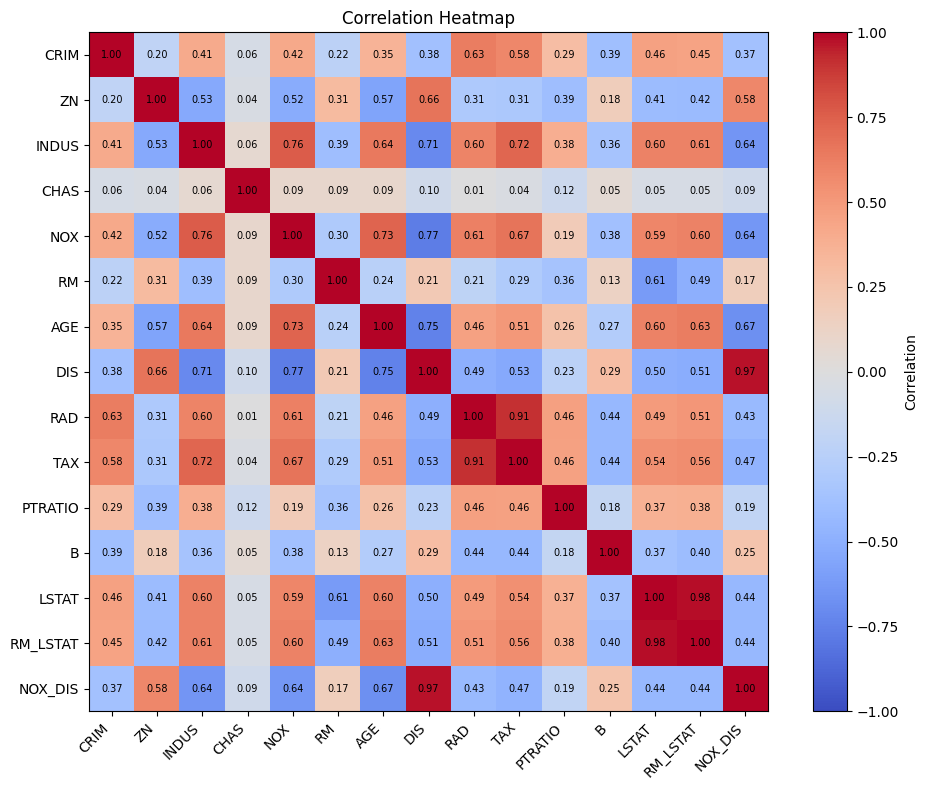

In [1410]:
# Top-10 absolute correlations among features(heatmap allowed)

#.corr() -> computers Pearson correlation between features
corr_matrix = df[features].corr().abs()


# #zero out diagonal -> each features is correlated with itself =1
corr_values = corr_matrix.values.copy()
# np.fill_diagonal(corr_values,0) # prevent appearing in top 10
corr_matrix = pd.DataFrame(corr_values, index=corr_matrix.index, columns=corr_matrix.columns)
number_of_features = len(features)

pairs = []
for i in range(number_of_features):
    for j in range(i + 1, number_of_features):
        pairs.append((features[i], features[j], corr_matrix.iloc[i,j]))

pairs.sort(key=lambda x: x[2], reverse=True) #sort the pairs by the absolute correlation in descending order
top10_pairs = pairs[:10]

print("Top 10 correlation features:")
for i, (f1, f2, c) in enumerate(pairs[:10]):
    print(f"  {i+1}. {f1:>10s} - {f2:<10s}: {c:.4f}")


#heapmap: 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(df[features].corr(), cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(np.arange(number_of_features))
ax.set_yticks(np.arange(number_of_features))
ax.set_xticklabels(features, rotation=45, ha="right")
ax.set_yticklabels(features)

# colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Correlation", rotation=90)

annotate = True
if annotate:
    for i in range(number_of_features):
        for j in range(number_of_features):
            ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", fontsize=7)

ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [1411]:
#1.3 1C. Implementations (From Scratch)
#1. OLS: implement fit and predict using pseudo-inverse.

def add_intercept(X: np.ndarray):
    return np.c_[np.ones((X.shape[0], 1)), X] 

class OLS:
    def __init__(self, fit_intercept: bool = True):
        self.fit_intercept = fit_intercept
        self.coef_ = None # this is where the learned parameters will be stored after fit()

    def fit(self, X: np.ndarray, y: np.ndarray):
        X_modified = add_intercept(X) if self.fit_intercept else X

        # β = X^+ y
        # In ML, X is often not square, np.linalg.pinv() returns a matrix X^+ such that it behaves like
        # an inverse even when a true inverse does not exist.
        self.coef_ = np.linalg.pinv(X_modified) @ y
        return self

    def predict(self, X):
        X_modified = add_intercept(X) if self.fit_intercept else X
        return X_modified @ self.coef_
    
#2. Ridge: implement closed-form ridge solution.

class RidgeClosedForm:
    def __init__(self, alpha: float = 1.0, fit_intercept: bool = True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept
        self.coef_ = None

    def fit(self, X, y):
        X_design = add_intercept(X) if self.fit_intercept else X

        num_of_features = X_design.shape[1]

        I = np.eye(num_of_features)
        
        reg_matrix = self.alpha * I
        reg_matrix[0,0] = 0 # no regularization on inercept
        self.coef_ = np.linalg.solve(X_design.T @ X_design + reg_matrix, X_design.T @ y)
        return self
    
    def predict(self, X):
        X_design = add_intercept(X)
        return X_design @ self.coef_


#3. Lasso: implement coordinate descent with soft-thresholding. No calling sklearn.Lasso.fit() for the main solution.  
class LassoCoordinateDescent:   
        def __init__(self, lam=1.0, max_iterations: int = 5000,convergence_tolerance: float = 1e-6, fit_intercept=True):
            self.lam = lam
            self.max_iterations = max_iterations
            self.convergence_tolerance = convergence_tolerance
            self.fit_intercept = fit_intercept
            self.beta = None
            self.objectives = []
            
        def _add_intercept(self, X):
            if not self.fit_intercept:
                return X
            ones = np.ones((X.shape[0], 1))
            return np.c_[ones, X]

        def soft_threshold(self, rho, lam):
            if rho > lam:
                return rho - lam
            if rho < -lam:
                return rho + lam
            return 0.0
        #rho -> measures how strongly one feature is correlated with the remaining error
   
        def objective_(self, X, y):
            residual = y - X @ self.beta
            if self.fit_intercept:
                # do not penalize intercept (beta[0])
                penalty = np.sum(np.abs(self.beta[1:]))
            else:
                penalty = np.sum(np.abs(self.beta))
            return 0.5 * np.mean(residual ** 2) + self.lam * penalty
        
        def fit(self, X, y):
            X = np.asarray(X, dtype=float)
            y = np.asarray(y, dtype=float).reshape(-1)

            X = self._add_intercept(X)

            num_of_samples, num_of_features = X.shape

            #initialize the coefficient vector
            self.beta = np.zeros(num_of_features)

            #iterate until converge or reach maximum allowed times
            for _ in range(self.max_iterations):
                #Saves the old values for convergence checking.
                beta_old = self.beta.copy()
            
                for j in range(num_of_features):
                    
                    # computer residual without j-th feature
                    # X @ self.beta is the full residual using current model.
                    # X @ self.beta - X[:, j] * self.beta[j] -> remove feature j's contribution
                    r_j = y - (X @ self.beta - X[:, j] * self.beta[j]) 
                    
                    #Compute correlation between residul_j and X_j
                    rho_j = (X[:, j] @ r_j)/num_of_samples

                    #normalization
                    z_j = (X[:,j] @ X[:,j])/num_of_samples

                    #update coefficent beta[j]
                    if j == 0:
                        self.beta[j] = rho_j /z_j
                    else:
                        self.beta[j] = self.soft_threshold(rho_j, self.lam) / z_j   

                obj = self.objective_(X,y)                    
                self.objectives.append(obj)
                
                #to find the largest coefficient change, and compared to convergence tolerance
                if np.max(np.abs(self.beta - beta_old)) < self.convergence_tolerance :
                    break
            return self

        def predict(self, X):
            X = self._add_intercept(X)
            return X @ self.beta

   

In [1412]:
# 1.4 1D. Experiments & Required Plots
# Use λ ∈ {0, 0.1, 0.5, 1, 2, 5, 10}. Report for each λ:
# • Train/val/test MSE
# • R2 on test set
import matplotlib.pyplot as plt

def mse(y_true, y_pred):
    return float(np.mean((y_true - y_pred) ** 2))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2) #residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) #total sum of sqaures
    return float(1.0 - ss_res / ss_tot) if ss_tot != 0 else 0.0


# standard scaling is used here
y_train = df.iloc[train_index][target].values.astype(float)
y_val = df.iloc[validation_index][target].values.astype(float)
y_test = df.iloc[test_index][target].values.astype(float)

lambdas = [0, 0.1, 0.5, 1, 2, 5, 10]


In [1413]:
#OLS
print("OLS Results: ")
ols = OLS(fit_intercept=True).fit(train_standard_scaling, y_train)
ols_train_mse = mse(y_train, ols.predict(train_standard_scaling))
ols_val_mse = mse(y_val, ols.predict(validation_standard_scaling))
ols_test_mse = mse(y_test, ols.predict(test_standard_scaling))
ols_test_r2 = r2_score(y_test,ols.predict(test_standard_scaling))
print(f"Train MSE: {ols_train_mse:.2f}")
print(f"Validation MSE: {ols_val_mse:.2f}")
print(f"Test MSE: {ols_test_mse:.2f}")
print(f"Test R^2: {ols_test_r2:.2f}")

OLS Results: 
Train MSE: 18.51
Validation MSE: 11.83
Test MSE: 18.08
Test R^2: 0.81


In [1414]:
# Ridge
print("Ridge Results: ")

ridge_results = {'lambda': [], 'train_mse': [], 'val_mse': [], 'test_mse': [],
                 'test_r2': [], 'coefficients': []}

for lam in lambdas:
    model = RidgeClosedForm(alpha=lam, fit_intercept=True).fit(train_standard_scaling, y_train)
    ridge_train_mse = mse(y_train, model.predict(train_standard_scaling))
    ridge_val_mse = mse(y_val, model.predict(validation_standard_scaling))
    ridge_test_mse = mse(y_test, model.predict(test_standard_scaling))
    ridge_test_r2 = r2_score(y_test, model.predict(test_standard_scaling))

    ridge_results['lambda'].append(lam)
    ridge_results['train_mse'].append(ridge_train_mse)
    ridge_results['val_mse'].append(ridge_val_mse)
    ridge_results['test_mse'].append(ridge_test_mse)
    ridge_results['test_r2'].append(ridge_test_r2)
    ridge_results['coefficients'].append(model.coef_.copy())

    print(f"λ={lam:>5.1f}: Train MSE={ridge_train_mse:3f}, Validation MSE={ridge_val_mse:.3f}, Test MSE={ridge_test_mse:.3f}, Test R^2={ridge_test_r2:.3f}")

Ridge Results: 
λ=  0.0: Train MSE=18.514029, Validation MSE=11.831, Test MSE=18.076, Test R^2=0.808
λ=  0.1: Train MSE=18.518711, Validation MSE=11.720, Test MSE=18.157, Test R^2=0.807
λ=  0.5: Train MSE=18.602571, Validation MSE=11.484, Test MSE=18.515, Test R^2=0.804
λ=  1.0: Train MSE=18.776413, Validation MSE=11.445, Test MSE=18.970, Test R^2=0.799
λ=  2.0: Train MSE=19.158714, Validation MSE=11.649, Test MSE=19.756, Test R^2=0.790
λ=  5.0: Train MSE=20.023679, Validation MSE=12.360, Test MSE=21.201, Test R^2=0.775
λ= 10.0: Train MSE=20.814907, Validation MSE=12.924, Test MSE=22.299, Test R^2=0.764


In [1415]:
# Lasso 
print("Lasso Results: ")

lasso_results = {'lambda': [], 'train_mse': [], 'val_mse': [], 'test_mse': [],
                 'test_r2': [], 'coefficients': [], 'objectives': []}

for lam in lambdas:
    lam_plot = lam if lam > 0 else 1e-10 #when lam is 0, it is not lasso anymore, it is OLS
    model = LassoCoordinateDescent(lam=lam_plot, max_iterations=5000, convergence_tolerance=1e-7, fit_intercept=True).fit(train_standard_scaling, y_train)
    lasso_train_mse = mse(y_train, model.predict(train_standard_scaling))
    lasso_val_mse = mse(y_val, model.predict(validation_standard_scaling))
    lasso_test_mse = mse(y_test, model.predict(test_standard_scaling))
    lasso_test_r2 = r2_score(y_test, model.predict(test_standard_scaling))

    lasso_results['lambda'].append(lam)
    lasso_results['train_mse'].append(lasso_train_mse)
    lasso_results['val_mse'].append(lasso_val_mse)
    lasso_results['test_mse'].append(lasso_test_mse)
    lasso_results['test_r2'].append(lasso_test_r2)
    lasso_results['coefficients'].append(model.beta.copy())
    lasso_results['objectives'].append(model.objectives)

    n_zero = np.sum(np.abs(model.beta[1:]) < 1e-8) #to check how many coefficient has less than convergence tolerance or become 0
    print(f"λ={lam:>5.1f}: Train MSE={lasso_train_mse:.4f}, Validation MSE={lasso_val_mse:.4f}, "
          f"Test MSE={lasso_test_mse:.4f}, Test R^2={lasso_test_r2:.4f}, Zero coeeficient={n_zero}")

Lasso Results: 
λ=  0.0: Train MSE=18.5140, Validation MSE=11.8307, Test MSE=18.0761, Test R^2=0.8083, Zero coeeficient=0
λ=  0.1: Train MSE=21.2156, Validation MSE=12.8097, Test MSE=22.6640, Test R^2=0.7596, Zero coeeficient=2
λ=  0.5: Train MSE=24.8852, Validation MSE=13.5318, Test MSE=25.3008, Test R^2=0.7317, Zero coeeficient=8
λ=  1.0: Train MSE=28.4422, Validation MSE=15.9776, Test MSE=28.3878, Test R^2=0.6989, Zero coeeficient=11
λ=  2.0: Train MSE=33.9411, Validation MSE=18.6454, Test MSE=35.1886, Test R^2=0.6268, Zero coeeficient=12
λ=  5.0: Train MSE=64.1040, Validation MSE=41.8701, Test MSE=69.7882, Test R^2=0.2598, Zero coeeficient=14
λ= 10.0: Train MSE=87.3050, Validation MSE=66.1116, Test MSE=94.3439, Test R^2=-0.0006, Zero coeeficient=15


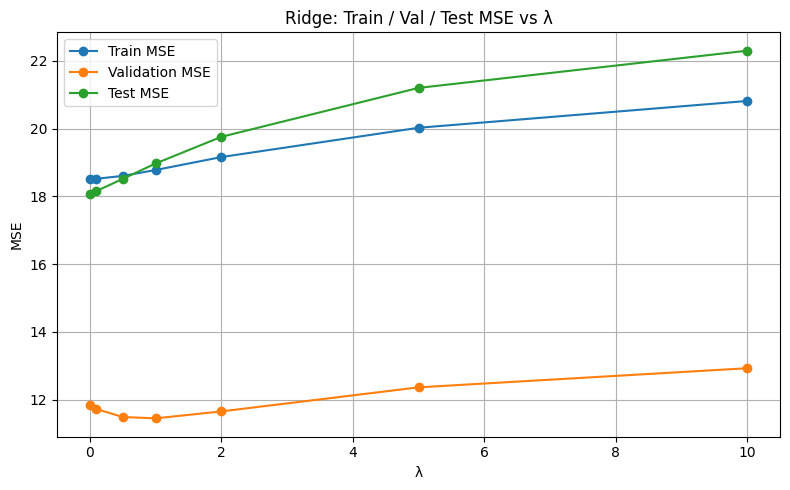

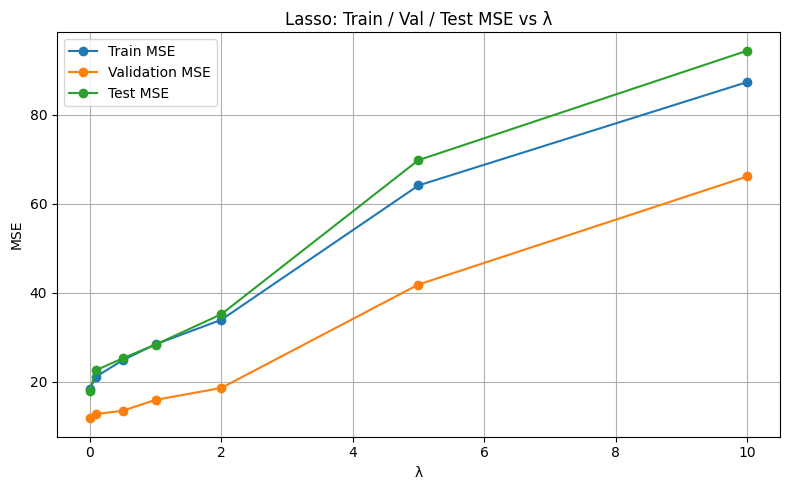

In [1416]:
# Required plots:
# Train/val/test MSE vs λ (Ridge and Lasso)

# for Ridge:
plt.figure(figsize=(8,5))

plt.plot(ridge_results["lambda"], ridge_results["train_mse"], marker='o', label='Train MSE')
plt.plot(ridge_results["lambda"], ridge_results["val_mse"], marker='o', label='Validation MSE')
plt.plot(ridge_results["lambda"], ridge_results["test_mse"], marker='o', label='Test MSE')
  
plt.xlabel('λ')
plt.ylabel('MSE')
plt.title('Ridge: Train / Val / Test MSE vs λ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# for Laaso
plt.figure(figsize=(8,5))

plt.plot(lasso_results["lambda"], lasso_results["train_mse"], marker='o', label='Train MSE')
plt.plot(lasso_results["lambda"], lasso_results["val_mse"], marker='o', label='Validation MSE')
plt.plot(lasso_results["lambda"], lasso_results["test_mse"], marker='o', label='Test MSE')

plt.xlabel('λ')
plt.ylabel('MSE')
plt.title('Lasso: Train / Val / Test MSE vs λ')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

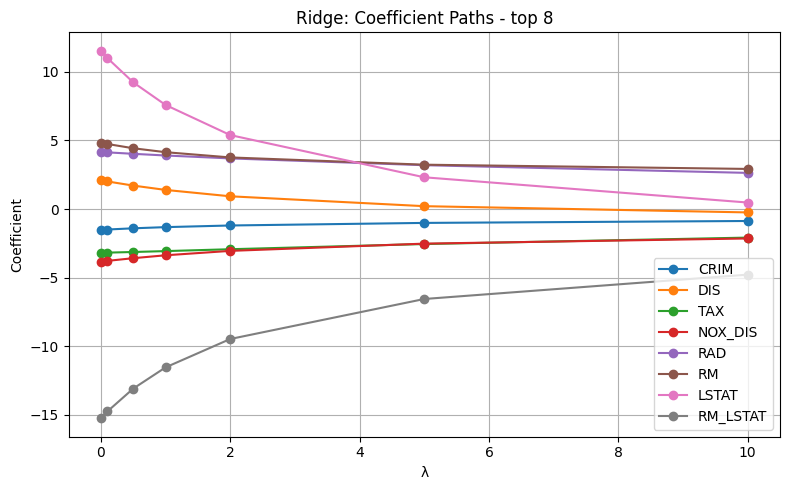

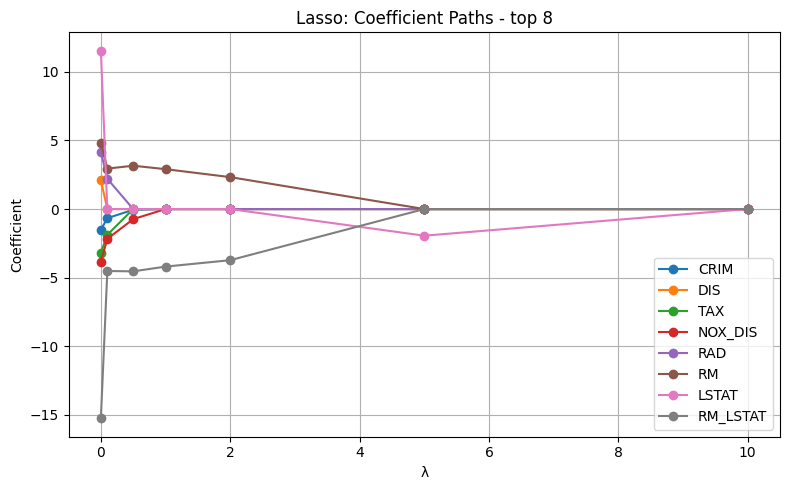

In [1417]:
# Coefficient paths vs λ (at least top 8 coefficients)

# for rigde
ridge_coef= np.array(ridge_results["coefficients"])

# lambda=0 -> when regularization is very weak -> identify the most important features
abs_coef_at_0 = np.abs(ridge_coef[0, 1:]) #skip intercept
index_top_8 = np.argsort(abs_coef_at_0)[-8:] + 1 

plt.figure(figsize=(8,5))

for i in index_top_8:
    plt.plot(ridge_results["lambda"], ridge_coef[:, i], marker='o', label=features[i-1])

plt.xlabel('λ')
plt.ylabel('Coefficient')
plt.title('Ridge: Coefficient Paths - top 8')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# for lasso
lasso_coef= np.array(lasso_results["coefficients"])

# lambda=0 -> when regularization is very weak -> identify the most important features
abs_coef_at_0 = np.abs(lasso_coef[0, 1:]) #skip intercept
index_top_8 = np.argsort(abs_coef_at_0)[-8:] + 1 

plt.figure(figsize=(8,5))

for i in index_top_8:
    plt.plot(lasso_results["lambda"], lasso_coef[:, i], marker='o', label=features[i-1])

plt.xlabel('λ')
plt.ylabel('Coefficient')
plt.title('Lasso: Coefficient Paths - top 8')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


len(lambdas): 7
len(objectives): 7


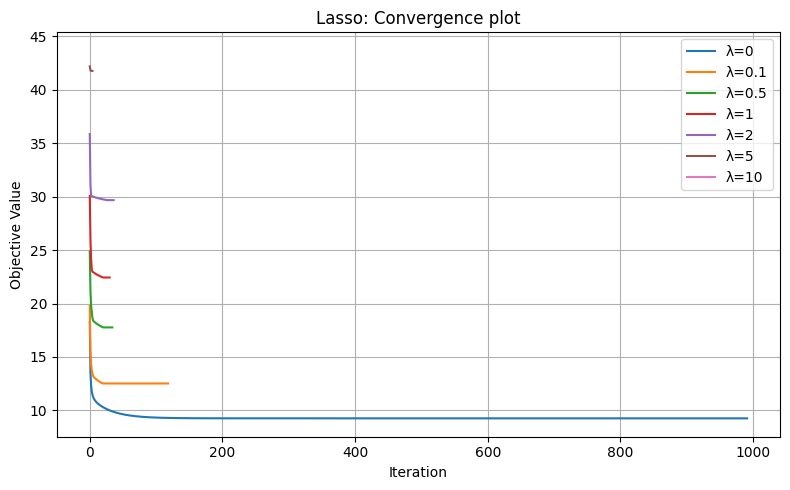

In [1418]:
# For Lasso: objective value vs iteration (convergence plot)
print("len(lambdas):", len(lambdas))
print("len(objectives):", len(lasso_results["objectives"]))


plt.figure(figsize=(8,5))
for i, lam in enumerate(lambdas):
    objs = lasso_results['objectives'][i]
    plt.plot(range(len(objs)), objs, label=f'λ={lam}')

plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Lasso: Convergence plot')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [1423]:
# 1.5 1E. Comparison & Mismatch Analysis
# Compare your fitted parameters and metrics with standard APIs.

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score


# OLS comparison
ols = OLS().fit(X_train, y_train)
sk_ols = LinearRegression().fit(X_train, y_train)
print(f"OLS Test MSE:")
print(f"from scratch: {mse(y_test, ols.predict(X_test))}")
print(f"from sklearn: {mean_squared_error(y_test, sk_ols.predict(X_test))}")
print("----------------------------------")

#Ridge
my_ridge = RidgeClosedForm(alpha=1.0).fit(X_train, y_train)
print(f"Ridge Test MSE:")
print(f"from scratch: {mse(y_test, my_ridge.predict(X_test))}")
sk_ridge = Ridge(alpha=1.0).fit(X_train, y_train)
print(f"from sklearn: {mean_squared_error(y_test, sk_ridge.predict(X_test))}")
print("----------------------------------")

#Lasso
my_lasso = LassoCoordinateDescent(lam=1.0, max_iterations=5000, convergence_tolerance=1e-7).fit(X_train, y_train)
print(f"Lasso Test MSE:")
print(f"from scratch: {mse(y_test, my_lasso.predict(X_test))}")

n_train_samples = X_train.shape[0] #sklearn lasso alpha = n_samples for equivalent formulation
sk_lasso = Lasso(alpha=1.0/n_train_samples,max_iter=10000, tol=1e-7).fit(X_train, y_train)
print(f"from sklearn: {mean_squared_error(y_test, sk_ols.predict(X_test))}")

      


OLS Test MSE:
from scratch: 18.076146527647495
from sklearn: 18.076146527647253
----------------------------------
Ridge Test MSE:
from scratch: 18.491555158530716
from sklearn: 18.491555158530538
----------------------------------
Lasso Test MSE:
from scratch: 31.596393845573512
from sklearn: 18.076146527647253


Analysis:
My implementations match well with sklearn for all 3 models. OLS and Ridge do relatively better than Lasso because they both use closed-form solutions. 

“Failure & Fix” Mini-Log (Required)
**Symptom**
The performance is overly well. 

**Evidence**:
"""
mu_train, sigma_train = standard_scaler_fit(X_train)
train_scaled = standard_scaler_transform(X_train, mu_train, sigma_train)

mu_val, sigma_val = standard_scaler_fit(X_val)
validation_scaled = standard_scaler_transform(X_val, mu_val, sigma_val)

mu_test, sigma_test = standard_scaler_fit(X_test)
test_scaled = standard_scaler_transform(X_test, mu_test, sigma_test)

"""

**Root cause**: is that scaling can only be performed from training data. Using validation and test statistics leaks the future information into the mode, leading to overly optimistic performance. 

**Fix**: 
"""
mu, sigma = standard_scaler_fit(X_train)

train_scaled = standard_scaler_transform(X_train, mu, sigma)
validation_scaled = standard_scaler_transform(X_val, mu, sigma)
test_scaled = standard_scaler_transform(X_test, mu, sigma)
"""